# ANN-to-SNN Conversion for a Multilayer Perceptron (MLP)

Download the Jupyter notebook : [MNIST_MLP.ipynb](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/docs/example/MNIST_MLP.ipynb)

This script will demonstrate the required steps to transform a multilayer perceptron trained on MNIST using TensorFlow into an SNN network usable in ANNarchy.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf


## Load MNIST

First we need to load the MNIST test and training which is already provided by tensorflow.

In [2]:
(X_train, t_train), (X_test, t_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 784).astype('float32') / 255.
X_test = X_test.reshape(X_test.shape[0], 784).astype('float32') / 255.
T_train = tf.keras.utils.to_categorical(t_train, 10)
T_test = tf.keras.utils.to_categorical(t_test, 10)

## TensorFlow MLP Architecture

The TensorFlow network was build with the functional API as follow:

```
inputs = tf.keras.layers.Input(shape=(784,))
h1= tf.keras.layers.Dense(64,use_bias=False, activation='relu')(inputs)
h2= tf.keras.layers.Dense(128,use_bias=False,activation='relu')(h1)
h3= tf.keras.layers.Dense(128,use_bias=False,activation='relu')(h2)
output=tf.keras.layers.Dense(10,use_bias=False,activation='softmax')(h3)

model= tf.keras.Model(inputs,output)

```

We used the standard gradient descent (SGD) optimizer and used the categorical crossentropy loss.

In [3]:
inputs = tf.keras.layers.Input(shape=(784,))
x= tf.keras.layers.Dense(128, 
                          use_bias=False, 
                          activation='relu')(inputs)
x= tf.keras.layers.Dense(128, 
                          use_bias=False,
                          activation='relu')(x)
x=tf.keras.layers.Dense(10, 
                          use_bias=False,
                          activation='softmax')(x)

model= tf.keras.Model(inputs, x)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

# Loss function
model.compile(
    loss='categorical_crossentropy', # loss function
    optimizer=optimizer, # learning rule
    metrics=['accuracy'] # show accuracy
)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 128)               100352    
                                                                 
 dense_1 (Dense)             (None, 128)               16384     
                                                                 
 dense_2 (Dense)             (None, 10)                1280      
                                                                 
Total params: 118,016
Trainable params: 118,016
Non-trainable params: 0
_________________________________________________________________
None


## Train the network

In [4]:
history = model.fit(
    X_train, T_train,       # training data
    batch_size=64,          # batch size
    epochs=20,              # Maximum number of epochs
    validation_split=0.1,   # Percentage of training data used for validation
)
model.save("mlp.h5")

Epoch 1/20
844/844 [==============================] - 2s 2ms/step - loss: 2.1470 - accuracy: 0.2679 - val_loss: 1.9424 - val_accuracy: 0.5258
Epoch 2/20
844/844 [==============================] - 2s 2ms/step - loss: 1.7387 - accuracy: 0.6002 - val_loss: 1.4718 - val_accuracy: 0.7128
Epoch 3/20
844/844 [==============================] - 2s 2ms/step - loss: 1.2911 - accuracy: 0.7227 - val_loss: 1.0457 - val_accuracy: 0.7947
Epoch 4/20
844/844 [==============================] - 2s 2ms/step - loss: 0.9628 - accuracy: 0.7854 - val_loss: 0.7804 - val_accuracy: 0.8410
Epoch 5/20
844/844 [==============================] - 2s 2ms/step - loss: 0.7694 - accuracy: 0.8179 - val_loss: 0.6285 - val_accuracy: 0.8638
Epoch 6/20
844/844 [==============================] - 2s 2ms/step - loss: 0.6547 - accuracy: 0.8379 - val_loss: 0.5359 - val_accuracy: 0.8768
Epoch 7/20
844/844 [==============================] - 2s 2ms/step - loss: 0.5811 - accuracy: 0.8501 - val_loss: 0.4749 - val_accuracy: 0.8875
Epoch 

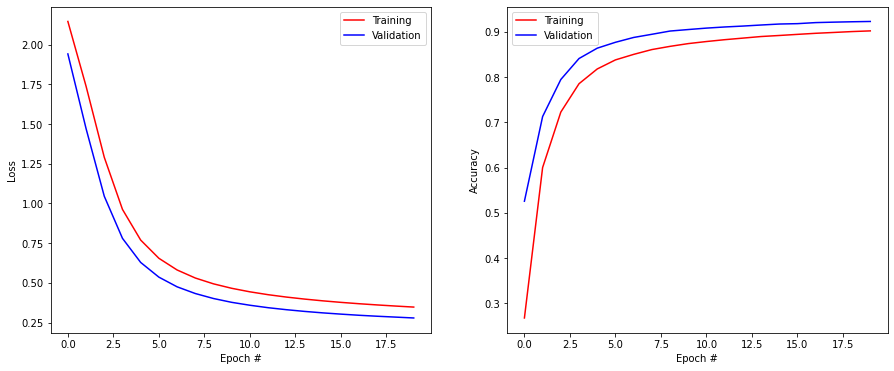

In [5]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(history.history['loss'], '-r', label="Training")
plt.plot(history.history['val_loss'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], '-r', label="Training")
plt.plot(history.history['val_accuracy'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [6]:
predictions_keras = model.predict(X_test)
test_loss, test_accuracy = model.evaluate(X_test, T_test)
print(f"Test accuracy: {test_accuracy}")

313/313 [==============================] - 0s 1ms/step - loss: 0.3221 - accuracy: 0.9099
Test accuracy: 0.9099000096321106


## Initialize the Converter

As the first step, we create an instance of the ANN-to-SNN conversion tool. The function receives the *input_encoding* parameter, which is the type of input encoding we want to use. By default, there are *intrinsically bursting* ("IB"), *phase shift oscillation* ("PSO"), *Poisson* ("poisson"), and *chattering* ("CH") available.

In [7]:
from ANNarchy.extensions.ann_to_snn_conversion import ANNtoSNNConverter
snn_converter = ANNtoSNNConverter(input_encoding='IB')

ANNarchy 4.7 (4.7.3b) on linux (posix).


After that, we provide the TensorFlow model stored as h5py file to the conversion tool. The print-out of the network structure of the imported network is suppressed when *show_info*=False is provided to *init_from_keras_model*.

In [8]:
snn_converter.init_from_keras_model("mlp.h5")


Selected In/Out
----------------------
input encoding: IB
read-out method: spike_count

Show populations/layer
----------------------
dense geometry =  128
dense_1 geometry =  128
dense_2 geometry =  10

Show Connections/Projections
----------------------
--------
input_1  ->  dense
(784,) (128,)
weight_m : (128, 784)
--------
dense  ->  dense_1
(128,) (128,)
weight_m : (128, 128)
--------
dense_1  ->  dense_2
(128,) (10,)
weight_m : (10, 128)
Compiling network 1...  OK 


## Inference for 10k Samples

When the network has been built successfully, we can perform a test using all MNIST training samples. Using *duration_per_sample* the number of steps for one image can be adjusted.

In [9]:
predictions_snn = snn_converter.predict(X_test, duration_per_sample=100)

100%|████████████████████████████████████| 10000/10000 [00:14<00:00, 672.86it/s]


Dependent on the selected read-out method it may happen that multiple neurons are selected. In the following, we select one of the candidates randomly.


In [10]:
from numpy.random import choice
predictions_snn = [ [choice(p)] for p in predictions_snn ]


## SNN

Using the recorded predictions, we can now compute the accuracy using scikit-learn for all presented samples.

In [11]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(t_test, predictions_snn))
print(accuracy_score(t_test, predictions_snn))


              precision    recall  f1-score   support

           0       0.91      0.98      0.94       980
           1       0.95      0.97      0.96      1135
           2       0.90      0.88      0.89      1032
           3       0.87      0.88      0.88      1010
           4       0.89      0.88      0.88       982
           5       0.89      0.77      0.82       892
           6       0.91      0.93      0.92       958
           7       0.91      0.89      0.90      1028
           8       0.82      0.88      0.85       974
           9       0.86      0.85      0.86      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

0.8922


## ANN

As ground-truth we can also analyze the predictions from the original ANN

In [12]:
print(classification_report(t_test, predictions_keras.argmax(axis=1)))
print(accuracy_score(t_test, predictions_keras.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       980
           1       0.96      0.98      0.97      1135
           2       0.91      0.88      0.90      1032
           3       0.90      0.89      0.89      1010
           4       0.89      0.93      0.91       982
           5       0.89      0.83      0.86       892
           6       0.92      0.94      0.93       958
           7       0.91      0.91      0.91      1028
           8       0.87      0.87      0.87       974
           9       0.90      0.87      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

0.9099


## ANN vs. SNN

A comparison between the predictions made by the ANN and SNN reveals potential different behavior.

In [13]:

print(classification_report(predictions_keras.argmax(axis=1), predictions_snn))
print(accuracy_score(predictions_keras.argmax(axis=1), predictions_snn))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1026
           1       0.98      0.99      0.98      1151
           2       0.95      0.95      0.95       998
           3       0.93      0.94      0.93      1004
           4       0.95      0.91      0.93      1020
           5       0.94      0.86      0.90       837
           6       0.95      0.96      0.96       981
           7       0.96      0.94      0.95      1028
           8       0.89      0.95      0.92       976
           9       0.90      0.92      0.91       979

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

0.9415


In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(predictions_keras.argmax(axis=1), predictions_snn)

array([[1010,    0,    2,    2,    0,    5,    3,    2,    1,    1],
       [   0, 1138,    1,    1,    0,    1,    0,    0,   10,    0],
       [   3,    5,  950,   11,    3,    1,    9,    1,   12,    3],
       [   4,    3,   11,  944,    1,   19,    0,    1,   19,    2],
       [   0,    2,    5,    0,  927,    2,   16,    2,    8,   58],
       [  16,    1,    3,   36,    2,  721,   12,    2,   38,    6],
       [   9,    1,    9,    0,    5,    9,  938,    0,   10,    0],
       [   2,    8,   10,    6,    1,    1,    0,  966,    5,   29],
       [   3,    5,   10,   14,    2,    6,    5,    2,  925,    4],
       [   1,    1,    3,    2,   33,    0,    0,   27,   16,  896]])